In [ ]:
# Cài đặt các thư viện cần thiết
!pip install torch torchvision torchaudio
!pip install transformers pyarrow datasets scikit-learn
!pip install accelerate -U
!pip install transformers[torch]
!pip install gensim

# HOÀN TOÀN CHẠY TRÊN GOOGLE COLAB

## Import Library

In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import pyarrow as pa
import numpy as np
from datasets import Dataset
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from google.colab import files
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

torch, pandas, numpy: Thư viện cơ bản cho deep learning và xử lý dữ liệu. torch cung cấp tensor và các ops cho deep learning. pandas và numpy cho xử lý dataframe và vectors.

transformers: Thư viện cho các mô hình BERT và transformer.

AutoTokenizer để tokenize text. AutoModelForSequenceClassification để huấn luyện BERT cho text classification.

sklearn: Thư viện machine learning phổ biến. Sử dụng để chia tập dữ liệu, đánh giá mô hình với metrics như accuracy, và các mô hình ML như LinearSVC.

pyarrow, datasets: Thư viện để xử lý dữ liệu lớn và tạo PyTorch datasets từ pandas dataframe.

TrainingArguments, Trainer: API huấn luyện mô hình PyTorch từ thư viện transformers.

keras: Thư viện deep learning phổ biến. Sử dụng để tokenize và padding sequences cho LSTM.

TfidfVectorizer, CountVectorizer: Vector hóa text trong ML dựa trên TF-IDF và Bag of Words.

classification_report: In ra metrics đánh giá mô hình classification.

## Read the dataset csv file

In [ ]:
# Tải file test.csv lên Google Colab
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
# Đọc dữ liệu từ file tải lên
df = pd.read_csv('train.csv', encoding='ISO-8859-1')
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


encoding='ISO-8859-1' định nghĩa kiểu mã hóa ký tự (character encoding) được sử dụng để đọc và ghi dữ liệu trong tệp CSV.

ISO-8859-1 là một chuẩn mã hóa ký tự phổ biến, bao gồm các ký tự Latin alphabet thông dụng trong nhiều ngôn ngữ châu Âu và phương Tây.

Đặc điểm của ISO-8859-1:

Mã hóa 1 byte cho mỗi ký tự, bao gồm các chữ cái, số, ký tự đặc biệt cơ bản, không hỗ trợ các ký tự tiếng Việt có dấu hoặc ký tự đặc biệt trong một số ngôn ngữ khác.

Khi đọc tệp CSV bằng Pandas, chúng ta cần chỉ định encoding phù hợp để đảm bảo dữ liệu được decode chính xác.

ISO-8859-1 là lựa chọn phổ biến nếu dữ liệu chủ yếu là tiếng Anh hoặc các ngôn ngữ châu Âu sử dụng Latin alphabet.

Các encoding khác như utf-8 hỗ trợ nhiều ký tự hơn cho các ngôn ngữ phức tạp hơn.

In [ ]:
# Đọc dữ liệu từ file tải lên và tiền xử lý
test_df_original = pd.read_csv('test.csv', encoding='ISO-8859-1')
test_processed = []

## Process the data

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# Khởi tạo tokenizer từ mô hình BERT pre-trained.
# BERT yêu cầu tokenize text thành các token trước khi đưa vào mô hình.

def process_data(row): # Định nghĩa hàm xử lý mỗi dòng dữ liệu.
    text = row['text'] # Lấy ra text từ mỗi row.
    text = str(text) # Ép kiểu về string cho đảm bảo.
    text = ' '.join(text.split()) # Xóa khoảng trắng thừa, chuẩn hóa khoảng trắng.

    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    # Tokenize text thành các tokens sử dụng tokenizer BERT.
    # Quy định độ dài cố định 128 tokens cho mỗi text bằng cách padding hoặc truncate.

    # Gán nhãn dựa trên giá trị của 'sentiment'
    if row['sentiment'] == 'negative':
        label = 0
    elif row['sentiment'] == 'neutral':
        label = 1
    else: # positive
        label = 2

    encodings['label'] = label
    encodings['text'] = text

    return encodings


In [ ]:
print(process_data({
    'text': 'this is a sample review of a movie.',
    'sentiment': 'positive'
}))

{'input_ids': [101, 2023, 2003, 1037, 7099, 3319, 1997, 1037, 3185, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
processed_data = []
# Khởi tạo list rỗng để lưu kết quả.

for i in range(len(df[:2000])):
    processed_data.append(process_data(df.iloc[i]))

# Lặp qua 2000 phần tử đầu tiên của df (chỉ lấy mẫu 2000 để demo)
# Lấy ra phần tử thứ i trong df
# Áp dụng hàm process_data đã định nghĩa trước đó
# kết quả vào list processed_data

# Như vậy, vòng lặp này sẽ lần lượt áp dụng process_data cho từng phần tử dữ liệu, rồi ghép tất cả kết quả vào list processed_data.
# Kết quả cuối cùng là processed_data là một list chứa encodings đã qua xử lý cho toàn bộ 2000 phần tử dữ liệu ban đầu.

## Generate the dataset

In [ ]:
# Giả định rằng df chính là DataFrame chứa tập dữ liệu của bạn
processed_data = df.apply(process_data, axis=1).tolist()

In [ ]:
from sklearn.model_selection import train_test_split

new_df = pd.DataFrame(processed_data) # Đưa dữ liệu đã xử lý ở trên vào DataFrame mới.
train_df, temp_df = train_test_split( # Chia ngẫu nhiên new_df thành 2 tập với tỷ lệ 8:2.
    new_df,
    stratify=new_df['label'],  # Chia theo cách giữ nguyên phân phối các nhãn trong 2 tập dữ liệu.
    test_size=0.2,
    random_state=2023
)
valid_df, test_df = train_test_split( # Chia tiếp temp_df thành 2 tập với tỷ lệ 1:1
    temp_df,
    stratify=temp_df['label'],
    test_size=0.5,
    random_state=2023
)
print(len(train_df))
print(len(valid_df))
print(len(test_df))

# Việc chia tập dữ liệu này giúp đánh giá mô hình một cách khách quan, tránh overfitting.

21984
2748
2749


In [ ]:
train_hg = Dataset(pa.Table.from_pandas(train_df)) # Chuyển train_df sang định dạng PyArrow Table
# Tối ưu hóa việc lưu trữ và truy xuất dữ liệu lớn hơn so với Pandas DataFrame.
# Hỗ trợ tốt hơn cho việc phân phối dữ liệu trên nhiều GPU.

valid_hg = Dataset(pa.Table.from_pandas(valid_df)) # Chuyển PyArrow Table sang Pytorch Dataset.
# Định dạng tối ưu cho việc huấn luyện PyTorch model.
# Cung cấp các hàm map, batch, shuffle... tiện lợi cho quá trình huấn luyện.

## Create a model

In [ ]:
# Tạo mô hình từ checkpoint 'bert-base-uncased' với 3 nhãn
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Thiết lập đường dẫn lưu trên Google Drive
SAVE_PATH = "/content/drive/My Drive/"  # Có thể thay đổi tên thư mục nếu muốn

Mounted at /content/drive


Huấn luyện mô hình BERT sử dụng thư viện Trainer của HuggingFace.

Khởi tạo TrainingArguments:

output_dir: thư mục lưu trữ kết quả huấn luyện

evaluation_strategy: đánh giá sau mỗi epoch

save_total_limit: giới hạn số lượng checkpoint lưu

num_train_epochs: số epoch huấn luyện

Khởi tạo Trainer:

model: mô hình BERT

args: tham số huấn luyện

train_dataset: tập huấn luyện

eval_dataset: tập validation

tokenizer: tokenizer đã khởi tạo

trainer.train(): bắt đầu quá trình huấn luyện

trainer.evaluate(): đánh giá mô hình trên tập validation

model.save_pretrained(): lưu trữ checkpoint mô hình đã huấn luyện

Trainer giúp khởi tạo vòng lặp huấn luyện, đánh giá mô hình một cách tự động và tiện lợi.

In [ ]:
training_args = TrainingArguments(output_dir=SAVE_PATH, evaluation_strategy="epoch", save_total_limit=2, num_train_epochs=5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hg,
    eval_dataset=valid_hg,
    tokenizer=tokenizer
)

trainer.train()
trainer.evaluate()
model.save_pretrained(SAVE_PATH)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.615700,0.529091
2,0.466100,0.638138
3,0.330400,0.807223
4,0.210300,1.061225
5,0.098000,1.254016


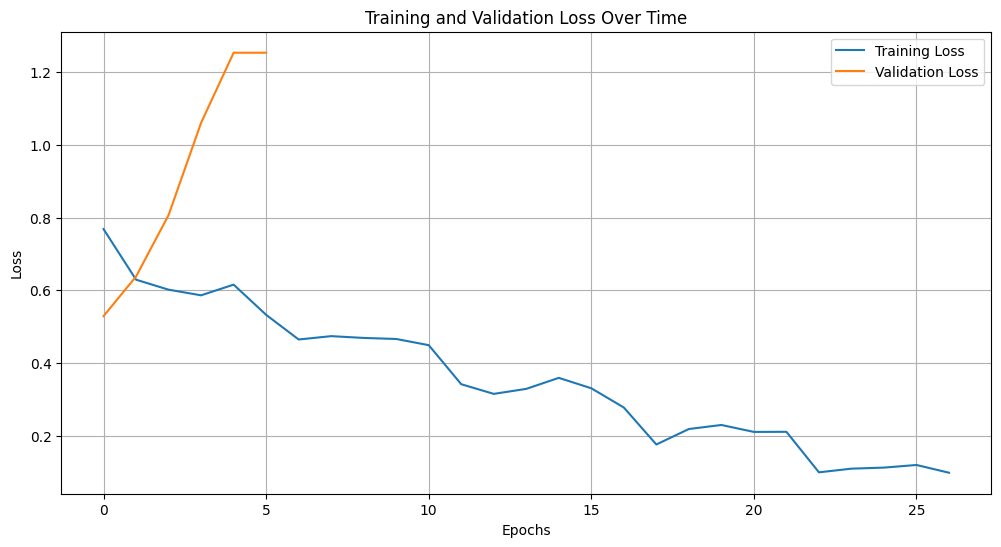

In [ ]:
import matplotlib.pyplot as plt

# Lấy dữ liệu từ lịch sử huấn luyện
training_history = trainer.state.log_history

# Lấy giá trị loss từ dữ liệu lịch sử
train_loss = [entry['loss'] for entry in training_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in training_history if 'eval_loss' in entry]

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_model = AutoModelForSequenceClassification.from_pretrained(SAVE_PATH).to(device)
new_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

## Train and Evaluate the model

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

`eval_loss:` Giá trị hàm mất mát (loss) trung bình trên tập validation. Đây là độ đo của sự sai lệch giữa dự đoán của mô hình và nhãn thực tế trên tập validation.

`eval_runtime:` Thời gian (đơn vị giây) mà quá trình đánh giá mô hình trên tập validation mất.

`eval_samples_per_second:` Số lượng mẫu (samples) được xử lý trên mỗi giây trong quá trình đánh giá mô hình trên tập validation. Đây là một chỉ số về hiệu suất xử lý của mô hình.

`eval_steps_per_second:` Số lượng bước lặp (steps) được xử lý trên mỗi giây trong quá trình đánh giá mô hình trên tập validation.

`epoch:` Số epoch (vòng lặp huấn luyện) khi mô hình được đánh giá trên tập validation.

## Save the model

In [ ]:
SAVE_PATH1 = "/content/drive/My Drive/model_bert_sentiment"
model.save_pretrained(SAVE_PATH1)
tokenizer.save_pretrained(SAVE_PATH1)

('/content/drive/My Drive/model_bert_sentiment/tokenizer_config.json',
 '/content/drive/My Drive/model_bert_sentiment/special_tokens_map.json',
 '/content/drive/My Drive/model_bert_sentiment/vocab.txt',
 '/content/drive/My Drive/model_bert_sentiment/added_tokens.json',
 '/content/drive/My Drive/model_bert_sentiment/tokenizer.json')

## Load the model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
new_model = AutoModelForSequenceClassification.from_pretrained(SAVE_PATH1).to(device)

In [ ]:
new_tokenizer = AutoTokenizer.from_pretrained(SAVE_PATH1)

## Get predictions

In [ ]:
import torch
import numpy as np
def get_prediction(text):
    # Tokenize and encode the input text
    encoding = new_tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    encoding = {k: v.to(device) for k, v in encoding.items()}

    # Forward pass through the model
    with torch.no_grad():
        outputs = new_model(**encoding)

    # Use softmax to compute probabilities for multi-class classification
    softmax = torch.nn.Softmax(dim=1)
    probs = softmax(outputs.logits).squeeze().cpu().detach().numpy()

    # Determine sentiment label based on probability
    label_idx = np.argmax(probs)
    labels_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    sentiment = labels_map[label_idx]
    probability = probs[label_idx]

    return {
        'sentiment': sentiment,
        'probability': probability
    }

### Tokenize, encode the input text and pass values ​​to device

In [ ]:
encoding = new_tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
encoding = {k: v.to(device) for k, v in encoding.items()}

- Dòng này bắt đầu bằng việc sử dụng `new_tokenizer` (tokenizer bạn đã tạo) để mã hóa và chia văn bản `text` thành một dạng có thể đưa vào mô hình. Kết quả là `encoding`, một từ điển chứa mã hóa của văn bản.

- Sau đó, mỗi giá trị trong `encoding` được chuyển đến thiết bị (device) mà mô hình đang sử dụng bằng cách sử dụng vòng lặp để lặp qua từng cặp key-value.

### Forward pass through the model

In [ ]:
with torch.no_grad():
    outputs = new_model(**encoding)

- Ở đây, mô hình `new_model` được áp dụng lên dữ liệu đã mã hóa thông qua việc truyền `encoding` vào mô hình. Kết quả là `outputs`, chứa các dự đoán và thông tin khác mà mô hình đã tính toán.

- Lệnh `with torch.no_grad()`: được sử dụng để tắt việc tính toán gradient trong quá trình dự đoán, giúp tối ưu hóa hiệu suất.

[link text](https://)### Compute probabilities using Softmax[link text](https://)

In [ ]:
# Use softmax to compute probabilities for multi-class classification
softmax = torch.nn.Softmax(dim=1)
probs = softmax(outputs.logits).squeeze().cpu().detach().numpy()

- Ở đây, chúng ta khởi tạo một hàm kích hoạt sigmoid để tính toán xác suất từ dự đoán của mô hình. Lưu ý rằng chúng ta sử dụng `outputs.logits` (đầu ra trực tiếp từ mô hình) và sau đó áp dụng sigmoid để có xác suất.

- logits.squeeze() được sử dụng để giảm một chiều của logits, chuyển từ tensor có kích thước `[batch_size, num_classes]` thành `[batch_size]`.

- `cpu()` được sử dụng để đảm bảo dữ liệu được chuyển về CPU nếu mô hình đang sử dụng GPU.

- `detach().numpy()` được sử dụng để chuyển tensor về mảng NumPy và loại bỏ gradient.

### Determine sentiment label based on probability and return results

In [ ]:
label_idx = np.argmax(probs)
    labels_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    sentiment = labels_map[label_idx]
    probability = probs[label_idx]

    return {
        'sentiment': sentiment,
        'probability': probability
    }

- Ở đây, chúng ta sử dụng `np.argmax(probs)` để xác định lớp có xác suất cao nhất từ mảng xác suất.

- Dựa vào nhãn được xác định, chúng ta xác định cảm xúc là "Positive" nếu nhãn là 2, Neutral nếu là 2 hoặc "Negative" nếu nhãn là 0.

- Xác suất liên quan được lấy từ mảng xác suất dự đoán.

- Kết quả cuối cùng của hàm là một từ điển chứa cảm xúc dự đoán và xác suất tương ứng.

### Predict results

In [ ]:
get_prediction('This meal is disgusting')

{'sentiment': 'Negative', 'probability': 0.9989249}

## Evaluate the model after checking the appropriate metrics

### Create a new table with 3 columns: text, label, and predict_label

In [ ]:
# Apply get_prediction to test data and create a new column for the predicted labels
tableEvaluate = test_df[['text', 'label']].copy()
predictions = test_df['text'].apply(get_prediction)
tableEvaluate['predicted_sentiment'] = predictions.apply(lambda x: x['sentiment'])
display(tableEvaluate)

,text,label,predicted_sentiment
25433,"I`ve had that 'problem' too, being charmed fas...",0,Neutral
26046,eating halls cuz i have a sour throte,1,Negative
22362,"my grandpa called, wants to know what you are ...",1,Neutral
7583,Almost got sharpied in the face while falling ...,0,Negative
21877,I ake it you`re at work then and not lazing at...,2,Neutral
...,...,...,...
25693,off to work now,1,Neutral
10305,just going through some of his tracks in iTune...,2,Positive
26268,"Well, I discovered I can`t swim. I`m out. Sorry",0,Negative
15224,I have to admit at being a Colin Firth groupie...,1,Neutral


Dự đoán nhãn cảm xúc cho tập dữ liệu test và đánh giá mô hình.

Cụ thể:

tableEvaluate = test_df[['text', 'label']].copy(): Tạo bản sao của test_df chứa cột text và label.

predictions = test_df['text'].apply(get_prediction):

Áp dụng hàm get_prediction đã định nghĩa trước đó cho mỗi text trong test_df

Trả về list các dict chứa cảm xúc dự đoán cho mỗi text.

tableEvaluate['predicted_sentiment'] = predictions.apply(lambda x: x['sentiment']):

Lấy ra giá trị 'sentiment' từ dict kết quả dự đoán

Gán vào cột predicted_sentiment của bảng đánh giá

display(tableEvaluate): Hiển thị bảng đánh giá chứa cả nhãn thật và nhãn dự đoán.

Như vậy ta có được bảng so sánh kết quả dự đoán với nhãn thật để đánh giá mô hình.

Các metric đánh giá chi tiết hơn có thể tính toán dựa trên 2 cột nhãn này.

### Evaluate the model with metrics such as accuracy, precision, recall, and F1-Score

In [ ]:
# Convert string labels to integers
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
tableEvaluate['predicted_label'] = tableEvaluate['predicted_sentiment'].map(label_map)

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(tableEvaluate['label'], tableEvaluate['predicted_label'])
# Assuming that Positive is the "positive" class
precision = precision_score(tableEvaluate['label'], tableEvaluate['predicted_label'], average='weighted')
recall = recall_score(tableEvaluate['label'], tableEvaluate['predicted_label'], average='weighted')
f1 = f1_score(tableEvaluate['label'], tableEvaluate['predicted_label'], average='weighted')

# Create a pandas DataFrame for evaluation results
evaluation_results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy, precision, recall, f1]
})
display(evaluation_results)

,Metric,Score
0,Accuracy,0.783921
1,Precision,0.785143
2,Recall,0.783921
3,F1-Score,0.784180


Tính toán và hiển thị các metric đánh giá mô hình dự đoán cảm xúc văn bản.

Cụ thể:

accuracy_score: Độ chính xác (tỷ lệ dự đoán đúng)

precision_score: Độ chính xác trong các dự đoán dương tính (cảm xúc Positive)

recall_score: Tỷ lệ phát hiện đúng các mẫu dương tính

f1_score: Điểm trung bình cân bằng giữa Precision và Recall

average='weighted': Tính trung bình các metric dựa trên tỷ lệ mẫu của mỗi lớp.

Hiển thị kết quả dưới dạng bảng để dễ theo dõi.

Những metric này cho phép đánh giá toàn diện khả năng dự đoán cảm xúc của mô hình, từ độ chính xác tổng thể đến khả năng phân lớp từng nhãn cảm xúc.

Việc tính toán và trực quan hóa các metric giúp dễ dàng đánh giá và cải thiện mô hình.

In [ ]:
# Load datasets
train_data = pd.read_csv('train.csv', encoding='ISO-8859-1')
test_data = pd.read_csv('test.csv', encoding='ISO-8859-1')

# Convert all text data to string type
train_data['text'] = train_data['text'].astype(str)
test_data['text'] = test_data['text'].astype(str)

# Replace any NaN values with a placeholder
train_data['text'].fillna('placeholder_text', inplace=True)
# Thay thế các giá trị NaN trong cột 'text' bằng 'placeholder_text'
test_data['text'].fillna('placeholder_text', inplace=True)

# Convert sentiment labels to strings and replace NaNs with placeholder
train_data['sentiment'] = train_data['sentiment'].astype(str).fillna('placeholder_sentiment')
# Ép kiểu cột 'sentiment' về string
test_data['sentiment'] = test_data['sentiment'].astype(str).fillna('placeholder_sentiment')
# Thay thế NaN trong cột 'sentiment' bằng giá trị placeholder

# Lý do:
# Tránh được lỗi khi máy học không xử lý được NaN
# Đảm bảo các nhãn sentiment đều có giá trị và kiểu string nhất quán
# Các placeholder sẽ bị loại bỏ trong quá trình huấn luyện
# sample(n) lấy ngẫu nhiên n mẫu dữ liệu để huấn luyện và kiểm tra nhanh. Giúp tránh OOM khi dữ liệu lớn.

# Use only a subset of data for quick demonstration and to prevent OOM (Out-of-Memory)
# Lấy mẫu ngẫu nhiên 5000 mẫu huấn luyện và 1000 mẫu kiểm tra từ tập dữ liệu ban đầu để tránh OOM.
SAMPLE_SIZE = 5000
train_data = train_data.sample(SAMPLE_SIZE, random_state=42)
test_data = test_data.sample(int(SAMPLE_SIZE * 0.2), random_state=42)

# Initialize the tokenizer
# Lấy mẫu ngẫu nhiên 5000 mẫu huấn luyện và 1000 mẫu...
# ...kiểm tra từ tập dữ liệu ban đầu để tránh OOM.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

# Tokenize the text data
# Áp dụng tokenizer đã huấn luyện cho cả tập huấn luyện
# và kiểm tra để chuyển các câu text thành sequences số.
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

# Padding sequences
# Sử dụng pad_sequences để căn chỉnh độ dài các sequences bằng cách padding 0 vào cuối.
# Độ dài là max length của các sequences trong tập huấn luyện.
X_train = pad_sequences(train_sequences)
X_test = pad_sequences(test_sequences, maxlen=X_train.shape[1])

# Kết quả là các ma trận X_train và X_test chứa các sequences có cùng độ dài, chuẩn bị đầu vào cho LSTM.

# Fit the encoder on the training data
# mã hoá nhãn text (positive/negative/neutral) sang dạng số (0, 1, 2). Chỉ fit trên tập huấn luyện.
le = LabelEncoder()
y_train = le.fit_transform(train_data['sentiment'])

# Find the unseen labels in the test set
# Kiểm tra các nhãn trong tập test có tồn tại trong tập huấn luyện không. Loại bỏ các nhãn chưa từng xuất hiện.
unseen_labels = set(test_data['sentiment'].unique()) - set(train_data['sentiment'].unique())

# Drop the rows with unseen labels in the test set
test_data = test_data[~test_data['sentiment'].isin(unseen_labels)]

# Now transform the test labels
y_test = le.transform(test_data['sentiment'])

# Split train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data into PyTorch tensors
X_train, y_train = torch.LongTensor(X_train), torch.LongTensor(y_train)
X_val, y_val = torch.LongTensor(X_val), torch.LongTensor(y_val)
X_test, y_test = torch.LongTensor(X_test), torch.LongTensor(y_test)

min_length = min(X_test.shape[0], y_test.shape[0])
X_test = X_test[:min_length]
y_test = y_test[:min_length]
# Áp dụng LabelEncoder đã huấn luyện cho tập test để mã hoá nhãn.
# Chia tập huấn luyện thành 2 tập huấn luyện và validation.
# Chuyển các numpy array sang torch.LongTensor để tương thích PyTorch.
# Cắt ngắn tập test để đảm bảo kích thước bằng tập nhãn.

# Define LSTM Model
import torch.nn as nn
import torch

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx) # Layer embedding để ánh xạ từng token trong sequence sang không gian vector có chiều embed_dim.
        self.rnn = nn.LSTM(embed_dim, hidden_dim) # Layer LSTM chính, nhận input là các vector đã embed và trả về output ở mỗi timestep.
        self.fc = nn.Linear(hidden_dim, output_dim) # Dense layer cuối cùng để ánh xạ từ không gian chiều hidden_dim của LSTM về không gian output_dim (số lớp nhãn).

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        # Use the last output of the sequence
        final_output = output[:, -1, :]
        return self.fc(final_output)
# Embed input sequences
# Truyền qua LSTM để thu được output
# Lấy output ở timestep cuối cùng làm đại diện cho cả sequence
# Truyền vào fc layer để thu được logits cho mỗi nhãn.

# Hyperparameters and model initialization
VOCAB_SIZE = len(tokenizer.word_index) + 1 # kích thước từ vựng, lấy từ số lượng từ đã học được bởi Keras Tokenizer.
EMBED_DIM = 100 # Chiều của không gian embedding.
HIDDEN_DIM = 256 # Số chiều ẩn của LSTM layer.
OUTPUT_DIM = 3 # Số lớp đầu ra tương ứng với số lớp nhãn phân loại.
PAD_IDX = 0 # Chỉ số của padding token, được bỏ qua trong quá trình huấn luyện.

model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX) # Khởi tạo đối tượng mô hình với các siêu tham số trên.
optimizer = optim.Adam(model.parameters()) # Sử dụng Adam để tối ưu hóa mô hình.
criterion = nn.CrossEntropyLoss() # Hàm loss dùng cross-entropy cho bài toán phân loại đa lớp.
# Training loop
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()

    optimizer.zero_grad()
    predictions = model(X_train)
    loss = criterion(predictions, y_train)
    loss.backward()
    optimizer.step()

    val_predictions = model(X_val)
    val_loss = criterion(val_predictions, y_val)
    print(f"Epoch: {epoch+1:02}, Train Loss: {loss:.3f}, Val Loss: {val_loss:.3f}")

# Adjust the model training and evaluation part
BATCH_SIZE = 64

# Convert data into Dataset and DataLoader for batching
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluation
model.eval()
all_preds = []
all_true = []

# Loop through the DataLoader batches
for batch_x, batch_y in test_loader:
    with torch.no_grad():
        predictions = model(batch_x)
        all_preds.extend(predictions.argmax(1).tolist())
        all_true.extend(batch_y.tolist())

# Calculate accuracy
acc = sum(np.array(all_preds) == np.array(all_true)) / len(all_true)
print(f"Test Accuracy: {acc*100:.2f}%")

# điều chỉnh cách đánh giá mô hình LSTM bằng cách sử dụng DataLoader và tính toán độ chính xác:
# Chuyển tensor thành Dataset rồi DataLoader để lấy batch.
# Dùng DataLoader lặp qua các batch của tập test.
# Mỗi batch thực hiện forward pass qua mô hình để dự đoán.
# Gom tất cả prediction và ground truth vào 2 list.
# So sánh prediction và ground truth để tính accuracy.
# Ưu điểm của DataLoader:
# Chia nhỏ dữ liệu thành các batch --> huấn luyện/đánh giá nhanh hơn.
# Tránh load toàn bộ dữ liệu vào GPU cùng lúc.

# Define BiLSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # We multiply the hidden_dim by 2 because it's bidirectional

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # Concatenate the final forward and backward hidden layers
        return self.fc(hidden)

# Hyperparameters and model initialization
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBED_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(np.unique(y_train))
PAD_IDX = 0

model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Adjust the model training and evaluation part
BATCH_SIZE = 64

# Convert data into Dataset and DataLoader for batching
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Tập validation không shuffle để đánh giá thứ tự.

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Convert data into Dataset and DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Tập train cho shuffle=True để trộn ngẫu nhiên các sample mỗi epoch.

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Ưu điểm của DataLoader:
# Huấn luyện theo từng batch thay vì cùng lúc toàn bộ dữ liệu --> nhanh + bộ nhớ thấp hơn.
# Dễ dàng hơn trong việc tùy chỉnh batch size, shuffle, load dữ liệu song song,...

# Training loop with DataLoader
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

    # Validation
    val_losses = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            val_predictions = model(batch_x)
            val_loss = criterion(val_predictions, batch_y)
            val_losses.append(val_loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)
    print(f"Epoch: {epoch+1:02}, Train Loss: {loss:.3f}, Avg Val Loss: {avg_val_loss:.3f}")

# Evaluation
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)
    test_loss = criterion(test_predictions.squeeze(1), y_test)
    acc = (test_predictions.argmax(1) == y_test).float().mean()
    print(f"Test Loss: {test_loss:.3f}, Test Acc: {acc*100:.2f}%")

y_train = le.fit_transform(train_data['sentiment'])
X_train_text, X_val_text, y_train, y_val = train_test_split(train_data['text'], y_train, test_size=0.2, random_state=42)
y_train_full = le.fit_transform(train_data['sentiment'])
X_train_text, X_val_text, y_train, y_val = train_test_split(train_data['text'], y_train_full, test_size=0.2, random_state=42)


# Adjust TF-IDF and Bag-of-Words vectorization
MAX_FEATURES = 2000
tfidf = TfidfVectorizer(max_features=2000)
bow_vectorizer = CountVectorizer(max_features=MAX_FEATURES)

# TF-IDF for SVM
# Split train into train-val text
# Fit on full training data
y_train_full = le.fit_transform(train_data['sentiment'])

# Now split
X_train_text, X_val_text, y_train, y_val = train_test_split(train_data['text'], y_train_full, test_size=0.2, random_state=42)
# Get test text
X_test_text = test_data['text']

# TF-IDF vectorization
X_train_tfidf = tfidf.fit_transform(X_train_text).toarray()
X_val_tfidf = tfidf.transform(X_val_text).toarray()
X_test_tfidf = tfidf.transform(X_test_text).toarray()

# Initialize and train the SVM model with TF-IDF
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

# Predictions for SVM with TF-IDF
train_preds = svm_model.predict(X_train_tfidf)
test_preds = svm_model.predict(X_test_tfidf)
print("\nTF-IDF SVM Test Classification Report:\n", classification_report(y_test, test_preds, target_names=["neutral", "positive", "negative"]))

# Bag-of-Words for SVM
bow_vectorizer = CountVectorizer(max_features=2000)
X_train_bow = bow_vectorizer.fit_transform(X_train_text).toarray()
X_val_bow = bow_vectorizer.transform(X_val_text).toarray()
X_test_bow = bow_vectorizer.transform(test_data['text']).toarray()

# Train and evaluate SVM for Bag-of-Words
svm_bow = LinearSVC().fit(X_train_bow, y_train)
test_preds_bow = svm_bow.predict(X_test_bow)
print("\nBag-of-Words SVM Test Classification Report:\n", classification_report(y_test, test_preds_bow, target_names=["neutral", "positive", "negative"]))

def get_w2v_features(text):
    """Transform a sentence into the average of its word2vec vectors."""
    tokens = text.split()
    vectors = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]

    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

# Word2Vec for SVM
from gensim.models import Word2Vec

w2v_model = Word2Vec(sentences=train_data['text'].str.split(), vector_size=100, window=5, min_count=1)
X_train_text, X_val_text, y_train_w2v, y_val_w2v = train_test_split(train_data['text'], train_data['sentiment'], test_size=0.2, random_state=42)
X_train_w2v = X_train_text.apply(get_w2v_features).tolist()
X_val_w2v = X_val_text.apply(get_w2v_features).tolist()
X_test_w2v = X_test_text.apply(get_w2v_features).tolist()

# Train and evaluate SVM for Word2Vec
svm_w2v = LinearSVC().fit(X_train_w2v, y_train_w2v)
test_preds_w2v = svm_w2v.predict(X_test_w2v)
# Convert integer labels back to original string labels
y_test_str = le.inverse_transform(y_test)
# Print the classification report
print("\nWord2Vec SVM Test Classification Report:\n",
      classification_report(y_test_str, test_preds_w2v, target_names=le.classes_))


Epoch: 01, Train Loss: 1.096, Val Loss: 1.090
Epoch: 02, Train Loss: 1.088, Val Loss: 1.086
Epoch: 03, Train Loss: 1.081, Val Loss: 1.082
Epoch: 04, Train Loss: 1.075, Val Loss: 1.080
Epoch: 05, Train Loss: 1.069, Val Loss: 1.077
Test Accuracy: 37.64%
Epoch: 01, Train Loss: 1.096, Avg Val Loss: 1.072
Epoch: 02, Train Loss: 1.102, Avg Val Loss: 1.071
Epoch: 03, Train Loss: 0.953, Avg Val Loss: 1.074
Epoch: 04, Train Loss: 0.952, Avg Val Loss: 1.082
Epoch: 05, Train Loss: 1.056, Avg Val Loss: 1.101
Test Loss: 1.158, Test Acc: 37.23%

TF-IDF SVM Test Classification Report:
               precision    recall  f1-score   support

     neutral       0.65      0.57      0.60       234
    positive       0.54      0.61      0.57       275
    negative       0.69      0.66      0.68       219

    accuracy                           0.61       728
   macro avg       0.62      0.61      0.62       728
weighted avg       0.62      0.61      0.61       728


Bag-of-Words SVM Test Classification Rep

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 01, Train Loss: 0.935, Avg Val Loss: 1.113
Epoch: 02, Train Loss: 0.902, Avg Val Loss: 1.132
Epoch: 03, Train Loss: 0.857, Avg Val Loss: 1.159
Epoch: 04, Train Loss: 0.815, Avg Val Loss: 1.206
Epoch: 05, Train Loss: 0.785, Avg Val Loss: 1.224


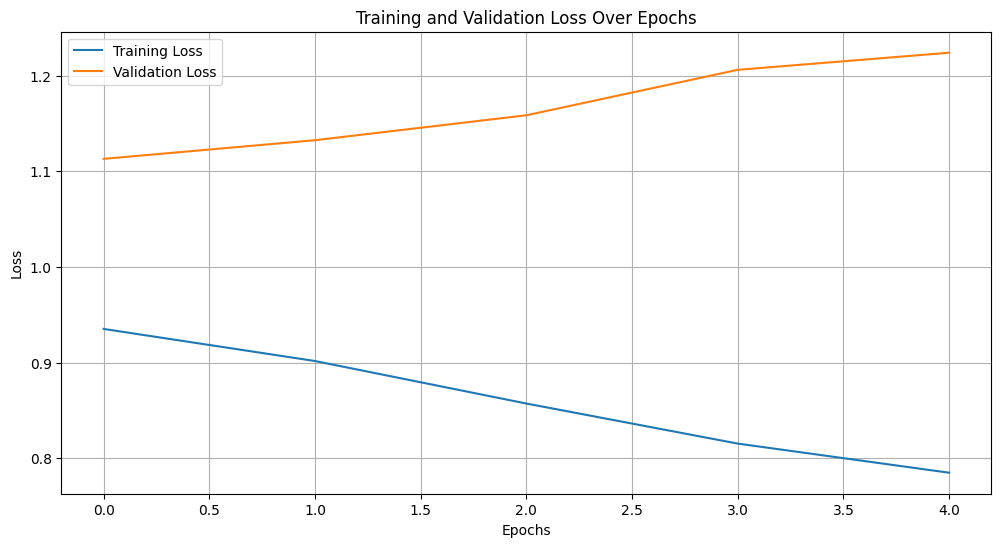

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

# Training loop with DataLoader
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    val_losses_epoch = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            val_predictions = model(batch_x)
            val_loss = criterion(val_predictions, batch_y)
            val_losses_epoch.append(val_loss.item())

    avg_val_loss = sum(val_losses_epoch) / len(val_losses_epoch)
    val_losses.append(avg_val_loss)
    print(f"Epoch: {epoch+1:02}, Train Loss: {avg_train_loss:.3f}, Avg Val Loss: {avg_val_loss:.3f}")

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

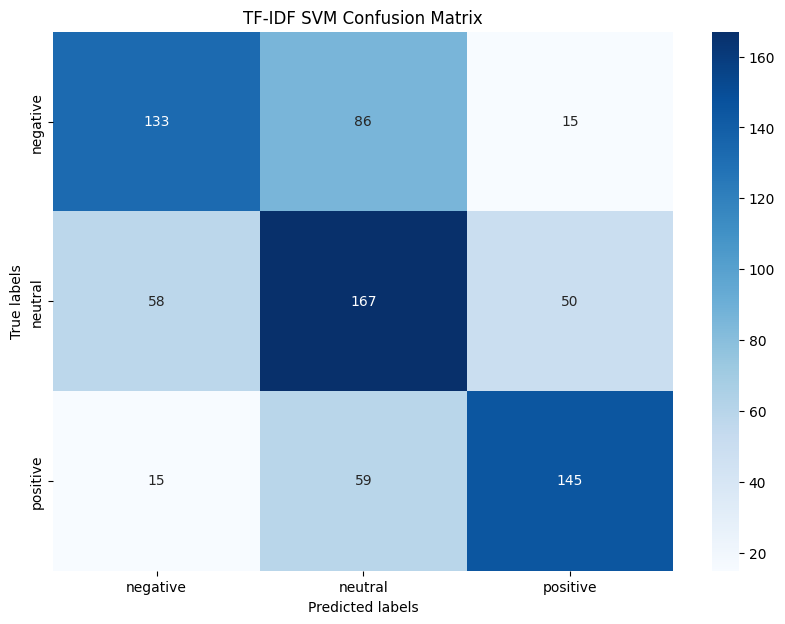

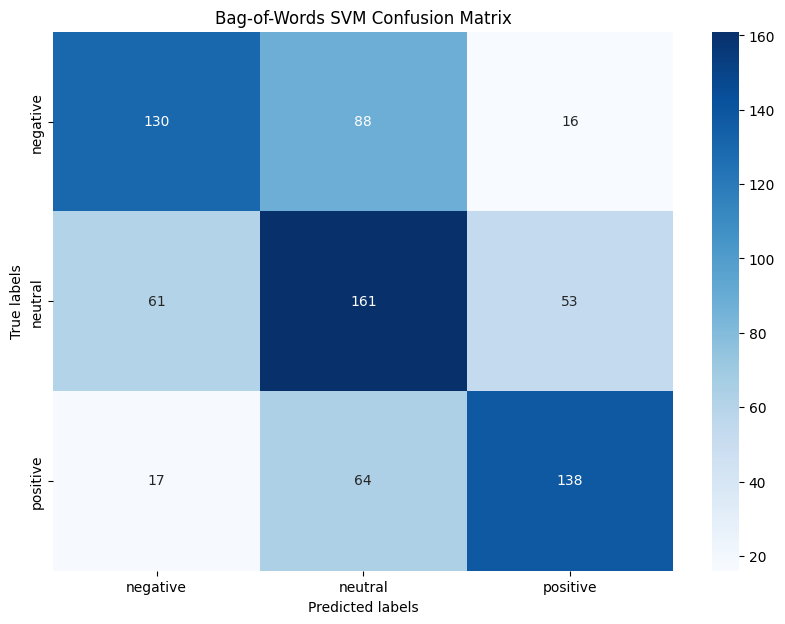

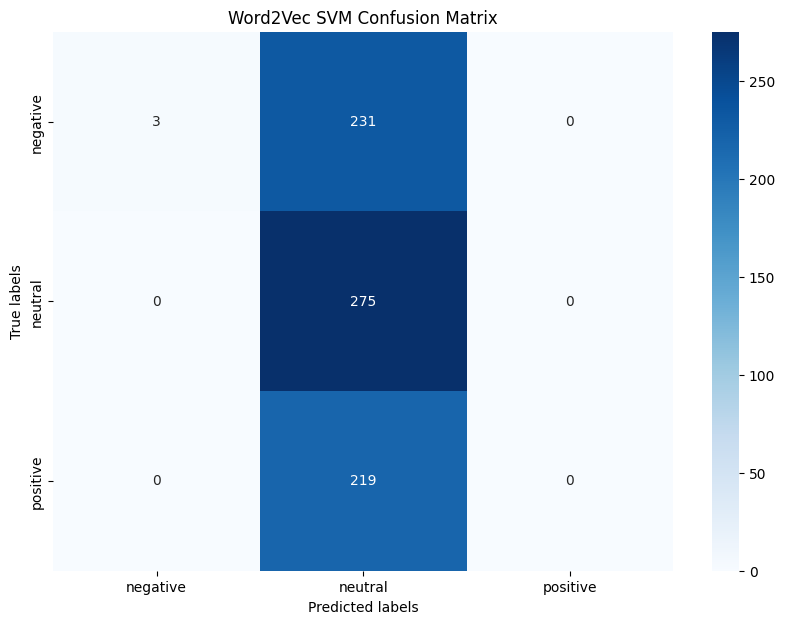

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

# For TF-IDF SVM
plot_confusion_matrix(y_test, test_preds, le.classes_, 'TF-IDF SVM Confusion Matrix')

# For Bag-of-Words SVM
plot_confusion_matrix(y_test, test_preds_bow, le.classes_, 'Bag-of-Words SVM Confusion Matrix')

# For Word2Vec SVM
plot_confusion_matrix(y_test_str, test_preds_w2v, le.classes_, 'Word2Vec SVM Confusion Matrix')